## Movie_Review_Sentiment_Classification
### (영화리뷰 감성분석)

***
#### 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import tensorflow as tf
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


***  
#### 2. 데이터로더 구성
> **1) 데이터의 중복 제거  
2) NaN 결측치 제거  
3) 한국어 토크나이저로 토큰화  
4) 불용어(Stopwords) 제거  
5) 사전word_to_index 구성  
6) 텍스트 스트링을 사전 인덱스 스트링으로 변환  
7) X_train, y_train, X_test, y_test, word_to_index 리턴**  

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    # 1-1) 학습데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
#     1-2) 학습데이터에서 NaN 결측치 제거
    train_data =train_data.dropna(how='any')
    
#     2-1) 테스트데이터의 중복 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
#     2-2) 테스트데이터의 NaN 결측치 제거
    test_data =train_data.dropna(how='any')
    
#     3-1) 학습데이터 한국어 토크나이저로 토큰화
    X_train = []
    for sentence in train_data['document']:
        # sentence에 있는 문장을 뜻을 가질수 있는 최소단위 '형태소'로 
        # 분리해서 토큰으로 가지고 있어줘
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어(stopwords) 제거
        # temp_X의 토큰을 X_train에 넣어줘.
        X_train.append(temp_X)

#     3-2) 테스트데이터 한국어 토크나이저로 토큰화
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어(stopwords) 제거
        X_test.append(temp_X)

#     5) 사전word_to_index 구성
    # np.concatenate(배열) : 해당 배열을 오른쪽에 추가하기
    # .tolost() : 앞의 배열을 np.unit이 아닌 list로 바꿔줌
    # => words는 X_train의 배열을 가진 list가 됨.
    words = np.concatenate(X_train).tolist()
    # Counter(words)
    # words에서 단어들의 갯수를 세어 {단어1:갯수, 단어2:갯수, ...} 형태의
    # 딕셔너리를 형성함.
    # ex) words = [가, 나, 가, 다, 나, 가, 라] 일때
    # Counter(words)를 하면
    # 결과물로 ({가:3, 나:2, 다:1, 라:1})의 형태임.
    counter = Counter(words)
    # counter.most_common(10000-4)
    # conter에서 가장 많이 사용된 단어를 [(단어1, 횟수),(단어2, 횟수), ...]의 형태로
    # 정렬하여 가장 많이 나온 횟수부터 가장 적게나온 횟수 순으로 (10000-4)개를 정렬해준다.
    counter = counter.most_common(10000-4)
    # vocab은 counter에 ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>']를 
    # 각각 key로서 넣는데 할당되지 않는 부분에서 넣는다.
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 인덱스 : 단어로 되어있는 부분을 단어 : 인덱스번호 형식으로 바꿔준다.
    word_to_index = {word:index for index, word in enumerate(vocab)}

#     6) 텍스트 스트링을 사전 인덱스 스트링으로 변환  
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    # map() 함수는 for문과 같은 반복문을 사용하지 않아도 
    # 지정한 함수로 인자를 여러번 전달해 그 결과를 list 형태로 
    # 뽑아 주는 유용한 함수이다.
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

#     7) X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
# 데이터의 갯수 확인
print('학습용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))

학습용 리뷰 개수 : 146183
테스트용 리뷰 개수 : 49158


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}
# 인덱스 : 단어 형태로 바꾸어준다.

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주었을 경우, 
# 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로
# encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 
# decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 
# 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### **3. 모델구성을 위한 데이터 분석 및 가공**
> **1) 데이터셋 내 문장 길이 분포  
> 2) 적절한 최대 문장 길이 지정  
> 3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가**


**1) 데이터셋 내 문장 길이 분포**

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이, 최대길이, 표준편차 확인
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.951608269143945
문장길이 최대 :  116
문장길이 표준편차 :  12.816614147489716


**2) 적절한 최대 문장 길이 지정**

In [9]:
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))
# 전체문장의 약 97%가 포함되도럭 설정

pad_sequences maxlen :  41
전체 문장의 0.9343694846150689%가 maxlen 설정값 이내에 포함됩니다. 


**3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가**

In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, padding='pre', 
                                                        maxlen=maxlen)
# PAD를 앞쪽에 배치하여야 소실되어도 학습이 잘 됨.

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


***
#### 4. 모델구성 및 validation set 구성
> **1) 1-D Convolution Neural Network(1-D CNN)  
> 2) GlobalMaxPooling1D()  
> 3) RNN  
> 4) 1-D CNN + RNN   
> 5) Validation set구성**


In [ ]:
# 파라미터를 고정시킴
vocab_size = len(index_to_word)  # 어휘 사전의 크기
word_vector_dim = 300    # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.

***
**1) 1-D Convolution Neural Network(1-D CNN)** 

In [13]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

**2) GlobalMaxPooling1D()**

In [14]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


**3) RNN**

In [23]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경가능)
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 3,020,433
Trainable params: 3,020,433
Non-trainable params: 0
_________________________________________________________________


**4) 1-D CNN + RNN**

In [24]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.MaxPooling1D(5))
model4.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경가능)
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 3,020,433
Trainable params: 3,020,433
Non-trainable params: 0
_________________________________________________________________


**5) Validation set구성**

In [17]:
# validation set 28000건 분리(전체 data의 약 20%)
X_val = X_train[:28000]   
y_val = y_train[:28000]

# validation set을 제외한 나머지 118182건
partial_X_train = X_train[28000:]  
partial_y_train = y_train[28000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(118182, 41)
(118182,)


#### 5. 모델 훈련 개시
***
**1) 1-D Convolution Neural Network(1-D CNN)** 

In [18]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model1.evaluate(X_test,  y_test, verbose=2)

print("1-D CNN모델",results)

Epoch 1/20
231/231 [==============================] - 20s 85ms/step - loss: 0.4383 - accuracy: 0.7949 - val_loss: 0.3388 - val_accuracy: 0.8526
Epoch 2/20
231/231 [==============================] - 10s 45ms/step - loss: 0.2980 - accuracy: 0.8755 - val_loss: 0.3268 - val_accuracy: 0.8562
Epoch 3/20
231/231 [==============================] - 11s 46ms/step - loss: 0.2329 - accuracy: 0.9087 - val_loss: 0.3533 - val_accuracy: 0.8531
Epoch 4/20
231/231 [==============================] - 10s 45ms/step - loss: 0.1635 - accuracy: 0.9413 - val_loss: 0.3853 - val_accuracy: 0.8504
Epoch 5/20
231/231 [==============================] - 11s 46ms/step - loss: 0.1047 - accuracy: 0.9652 - val_loss: 0.4778 - val_accuracy: 0.8443
Epoch 6/20
231/231 [==============================] - 10s 45ms/step - loss: 0.0686 - accuracy: 0.9779 - val_loss: 0.5415 - val_accuracy: 0.8411
Epoch 7/20
231/231 [==============================] - 10s 44ms/step - loss: 0.0462 - accuracy: 0.9854 - val_loss: 0.6251 - val_accuracy:

**1) 1-D Convolution Neural Network(1-D CNN)  
accuracy : 0.9651 // loss : 0.2428** 
***
**2) GlobalMaxPooling1D()**

In [19]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model2.evaluate(X_test,  y_test, verbose=2)

print("GlobalMaxPooling1D()모델",results)

Epoch 1/20
231/231 [==============================] - 10s 42ms/step - loss: 0.4771 - accuracy: 0.7870 - val_loss: 0.3482 - val_accuracy: 0.8453
Epoch 2/20
231/231 [==============================] - 10s 43ms/step - loss: 0.3131 - accuracy: 0.8688 - val_loss: 0.3355 - val_accuracy: 0.8530
Epoch 3/20
231/231 [==============================] - 10s 43ms/step - loss: 0.2649 - accuracy: 0.8925 - val_loss: 0.3414 - val_accuracy: 0.8551
Epoch 4/20
231/231 [==============================] - 10s 44ms/step - loss: 0.2228 - accuracy: 0.9134 - val_loss: 0.3553 - val_accuracy: 0.8540
Epoch 5/20
231/231 [==============================] - 11s 45ms/step - loss: 0.1799 - accuracy: 0.9341 - val_loss: 0.3776 - val_accuracy: 0.8527
Epoch 6/20
231/231 [==============================] - 10s 42ms/step - loss: 0.1369 - accuracy: 0.9546 - val_loss: 0.4123 - val_accuracy: 0.8505
Epoch 7/20
231/231 [==============================] - 11s 46ms/step - loss: 0.0977 - accuracy: 0.9713 - val_loss: 0.4519 - val_accuracy:

**2) GlobalMaxPooling1D()  
accuracy : 0.9671 // loss:0.1624** 
***
**3) RNN**

In [25]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model3.evaluate(X_test,  y_test, verbose=2)

print("RNN모델",results)

Epoch 1/20
231/231 [==============================] - 11s 47ms/step - loss: 0.4274 - accuracy: 0.8099 - val_loss: 0.3469 - val_accuracy: 0.8490
Epoch 2/20
231/231 [==============================] - 11s 48ms/step - loss: 0.3193 - accuracy: 0.8651 - val_loss: 0.3386 - val_accuracy: 0.8522
Epoch 3/20
231/231 [==============================] - 11s 48ms/step - loss: 0.2868 - accuracy: 0.8787 - val_loss: 0.3443 - val_accuracy: 0.8514
Epoch 4/20
231/231 [==============================] - 11s 46ms/step - loss: 0.2563 - accuracy: 0.8938 - val_loss: 0.3512 - val_accuracy: 0.8539
Epoch 5/20
231/231 [==============================] - 10s 45ms/step - loss: 0.2271 - accuracy: 0.9077 - val_loss: 0.3588 - val_accuracy: 0.8527
Epoch 6/20
231/231 [==============================] - 11s 46ms/step - loss: 0.2018 - accuracy: 0.9195 - val_loss: 0.3786 - val_accuracy: 0.8536
Epoch 7/20
231/231 [==============================] - 11s 46ms/step - loss: 0.1804 - accuracy: 0.9299 - val_loss: 0.4043 - val_accuracy:

**3) RNN  
accuracy : 0.9558 // loss:0.1940** 
***
**4) 1-D CNN + RNN**

In [21]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model4.evaluate(X_test,  y_test, verbose=2)

print("1-D CNN + RNN모델",results)

Epoch 1/20
231/231 [==============================] - 11s 46ms/step - loss: 0.5474 - accuracy: 0.7659 - val_loss: 0.4342 - val_accuracy: 0.8409
Epoch 2/20
231/231 [==============================] - 12s 54ms/step - loss: 0.3394 - accuracy: 0.8628 - val_loss: 0.3326 - val_accuracy: 0.8555
Epoch 3/20
231/231 [==============================] - 11s 47ms/step - loss: 0.2582 - accuracy: 0.8977 - val_loss: 0.3382 - val_accuracy: 0.8587
Epoch 4/20
231/231 [==============================] - 11s 48ms/step - loss: 0.1929 - accuracy: 0.9283 - val_loss: 0.3711 - val_accuracy: 0.8531
Epoch 5/20
231/231 [==============================] - 11s 49ms/step - loss: 0.1372 - accuracy: 0.9530 - val_loss: 0.4312 - val_accuracy: 0.8457
Epoch 6/20
231/231 [==============================] - 11s 47ms/step - loss: 0.0989 - accuracy: 0.9677 - val_loss: 0.4911 - val_accuracy: 0.8422
Epoch 7/20
231/231 [==============================] - 11s 46ms/step - loss: 0.0723 - accuracy: 0.9772 - val_loss: 0.5608 - val_accuracy:

**4) 1-D CNN + RNN  
accuracy : 0.9618 // loss:0.2278** 
***
#### 결과
**1) 1-D Convolution Neural Network(1-D CNN)  
accuracy : 0.9651 // loss : 0.2428**  
  
**2) GlobalMaxPooling1D()  
accuracy : 0.9671 // loss:0.1624**   
  
**3) RNN  
accuracy : 0.9558 // loss:0.1940**  
  
**4) 1-D CNN + RNN  
accuracy : 0.9618 // loss:0.2278**  
  
**=> 정확도가 가장 높은 `GlobalMaxPooling1D()모델`을 사용하는 것이 효과적으로 판단됨.**
***
#### 6. Loss, Accuracy 그래프 시각화

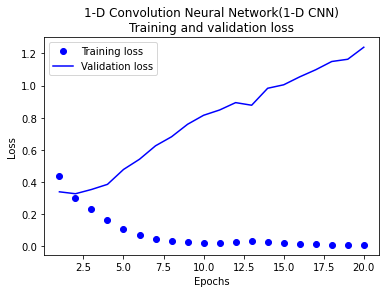

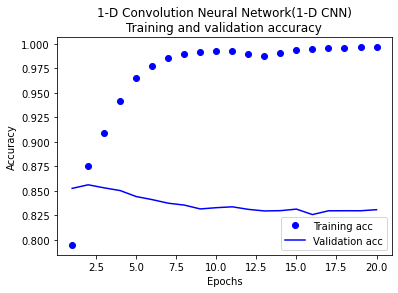

In [26]:
import matplotlib.pyplot as plt

history_dict1 = history1.history
acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('1-D Convolution Neural Network(1-D CNN)\nTraining and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('1-D Convolution Neural Network(1-D CNN)\nTraining and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

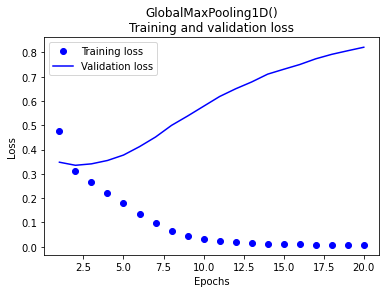

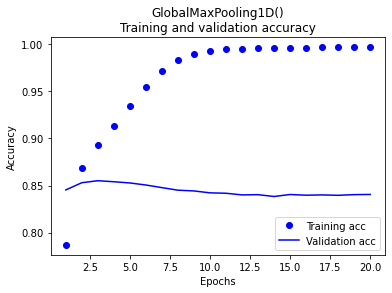

In [27]:
history_dict2 = history2.history
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobalMaxPooling1D()\nTraining and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobalMaxPooling1D()\nTraining and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

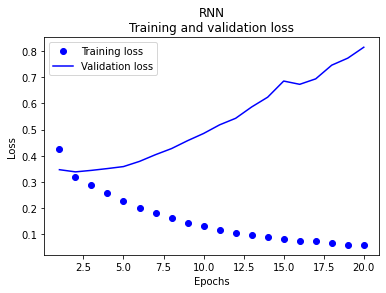

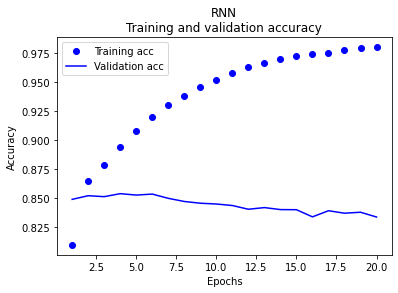

In [28]:
history_dict3 = history3.history
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN\nTraining and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN\nTraining and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

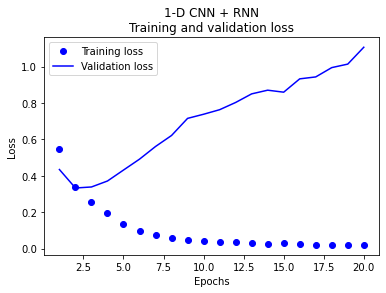

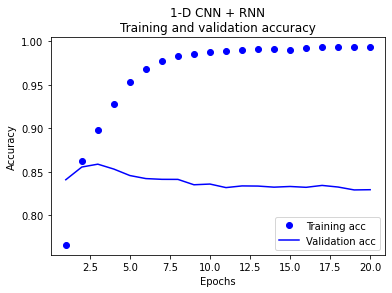

In [29]:
history_dict4 = history4.history
acc = history_dict4['accuracy']
val_acc = history_dict4['val_accuracy']
loss = history_dict4['loss']
val_loss = history_dict4['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('1-D CNN + RNN\nTraining and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('1-D CNN + RNN\nTraining and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 7. 학습된 Embedding 레이어 분석

In [34]:
embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
# word2vec의 파일 경로
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec1.txt'
# word2vec의 파일 열기
f = open(word2vec_file_path, 'w')
# word2vec의 파일 에서 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
# 사랑이란 단어에 관한 유사도 결과
word_vectors.similar_by_word("사랑")

(10000, 300)


[('음', 0.4957769513130188),
 ('에서', 0.47264164686203003),
 ('어', 0.46930432319641113),
 ('만든', 0.4674724340438843),
 ('이런', 0.46358296275138855),
 ('느낌', 0.4593355655670166),
 ('마지막', 0.45336347818374634),
 ('분위기', 0.44219082593917847),
 ('짱짱', 0.4409571886062622),
 ('우리', 0.4359704256057739)]

=> 유사도가 잘 느껴지지 않음.
=> 한국어 임베딩 활용 필요
***
#### 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [35]:
from gensim.models.word2vec import Word2Vec
korvec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
kovec = Word2Vec.load(korvec_file_path)
kovec.similar_by_word("사랑")

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [36]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in kovec:
        embedding_matrix[i] = kovec[index_to_word[i]]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [37]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [38]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=60,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
1970/1970 [==============================] - 43s 22ms/step - loss: 0.5838 - accuracy: 0.6804 - val_loss: 0.4768 - val_accuracy: 0.7716
Epoch 2/15
1970/1970 [==============================] - 42s 21ms/step - loss: 0.4404 - accuracy: 0.7947 - val_loss: 0.4215 - val_accuracy: 0.8041
Epoch 3/15
1970/1970 [==============================] - 43s 22ms/step - loss: 0.3870 - accuracy: 0.8259 - val_loss: 0.3988 - val_accuracy: 0.8179
Epoch 4/15
1970/1970 [==============================] - 42s 21ms/step - loss: 0.3522 - accuracy: 0.8459 - val_loss: 0.3882 - val_accuracy: 0.8262
Epoch 5/15
1970/1970 [==============================] - 42s 21ms/step - loss: 0.3243 - accuracy: 0.8610 - val_loss: 0.3874 - val_accuracy: 0.8301
Epoch 6/15
1970/1970 [==============================] - 42s 22ms/step - loss: 0.3001 - accuracy: 0.8736 - val_loss: 0.3864 - val_accuracy: 0.8310
Epoch 7/15
1970/1970 [==============================] - 42s 21ms/step - loss: 0.2782 - accuracy: 0.8843 - val_loss: 0.3882 -

In [39]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

4569/4569 - 8s - loss: 0.1946 - accuracy: 0.9356
[0.19458188116550446, 0.9355529546737671]


#### 결론
> **모델 학습결과**  
>**1) 1-D Convolution Neural Network(1-D CNN)  
> accuracy : 0.9265 // loss : 0.3184**  
>  
>**2) GlobalMaxPooling1D()  
> accuracy : 0.9625 // loss:0.1674**   
>  
>**3) RNN  
>accuracy : 0.9425 // loss:0.1977**  
>  
>**4) 1-D CNN + RNN  
>accuracy : 0.9229 // loss:0.2922**   
> **=>GlobalMaxPooling1D()로 학습시키는것이 낫다고 판단  
> GlobalMaxPooling1D()로 학습시킨 후 임베딩레이어를 분석한결과 성능이 비교적 좋지 않았으며,  
> 이를 한국어 Word2Vec 임베딩을 활용하여 성능을 개선하였다.
> 최종 테스트 결과는 [accuracy: 0.9377 // loss: 0.1916] 이다.**

***
#### 회고
> **생각보다 모델링을 만드는데 시간이 오래걸렸다. 기존의 노드들과는 다르게 직접 코드들의 관계를 파악하고 배치하고 설계해야해서 그랬던 것 같다. 고민하면서 진행하는 것은 생각보다 재미가 있었지만, 제대로 풀리지 않는 문제들을 끙끙대며 고민하는 과정이 생각보다 어려운 부분이었다. 이런 상황이 지속되었을 때 어떻게 해결해 나갈 것인각를 고민해봐야 하겠다.**